We consume news through several mediums throughout the day in our daily routine, but sometimes it
becomes difficult to decide which one is fake and which one is authentic.

Do you trust all the news you consume from online media?

Every news that we consume is not real. If you listen to fake news it means you are collecting the wrong
information from the world which can affect society because a person’s views or thoughts can change after
consuming fake news which the user perceives to be true.

Since all the news we encounter in our day-to-day life is not authentic, how do we categorize if the news is
fake or real?

In this article, we will focus on text-based news and try to build a model that will help us to identify if a
piece of given news is fake or real.

# Fake News Identification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import nltk
import datetime
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from nltk import tokenize,bigrams,trigrams

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
df_fake = pd.read_csv("/content/drive/My Drive/Colab Notebooks/csv_files/True.csv", encoding="cp1252")
df_true = pd.read_csv("/content/drive/My Drive/Colab Notebooks/csv_files/Fake.csv", encoding="cp1252")

In [4]:
df_fake.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
df_true.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obamas Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [7]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [8]:
df_fake["reaction"] = 1
df_true["reaction"] = 0

In [9]:
df_fake = df_fake.sample(frac=0.02, random_state = 6)
df_true = df_true.sample(frac=0.02, random_state = 6)

## Data Cleaning

In [10]:
df_true.subject.value_counts()

News               182
politics           129
left-news           97
Government News     41
Middle-east         12
US_News              9
Name: subject, dtype: int64

In [11]:
df_fake.subject.value_counts()

politicsNews    229
worldnews       199
Name: subject, dtype: int64

<Axes: xlabel='subject', ylabel='count'>

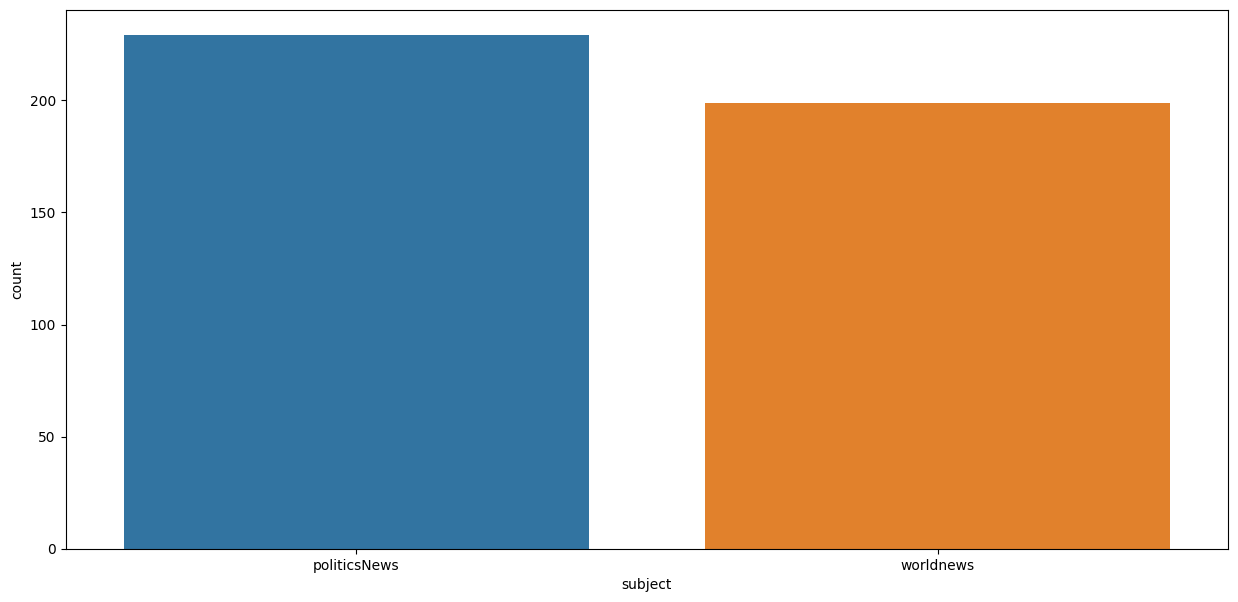

In [12]:
# number of subjects in fake data
plt.figure(figsize=(15,7))
sns.countplot(x = "subject", data = df_fake)

<Axes: xlabel='subject', ylabel='count'>

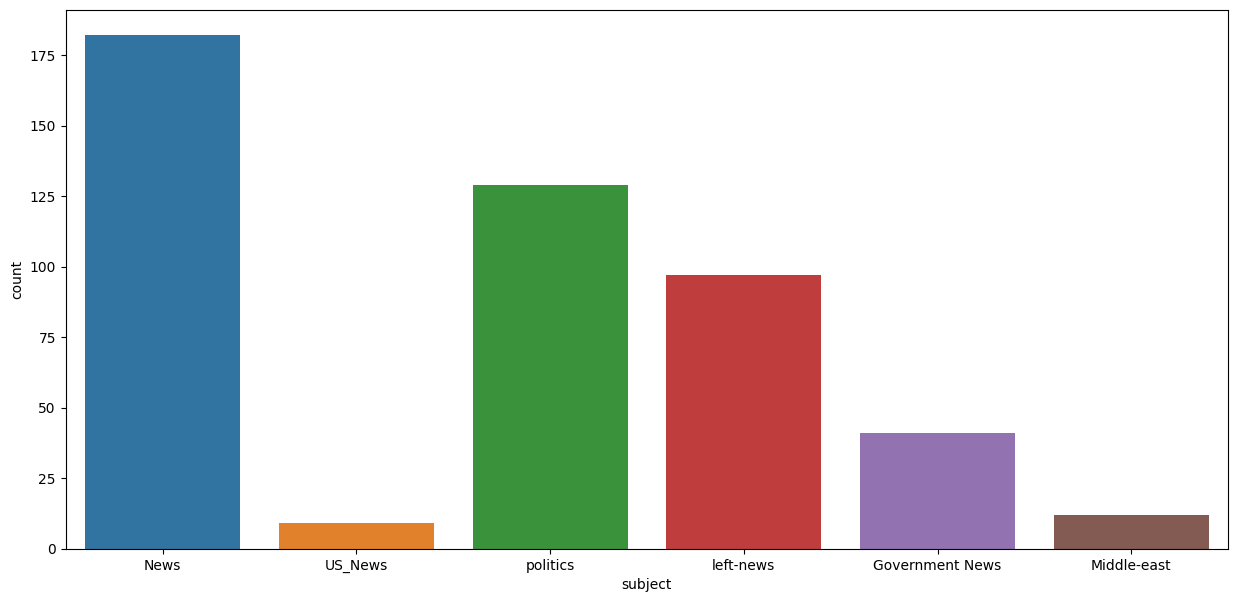

In [13]:
# number of subjects in true data
plt.figure(figsize=(15,7))
sns.countplot(x = "subject", data = df_true)

<Axes: ylabel='subject'>

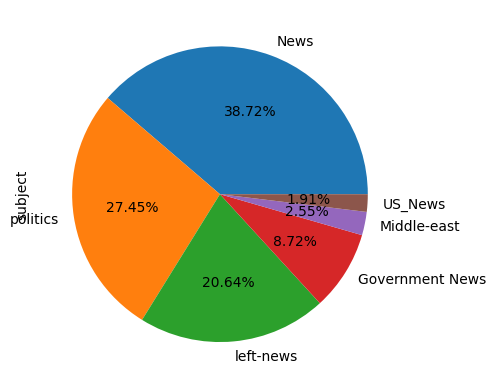

In [14]:
df_true.subject.value_counts().plot(kind = "pie", autopct='%.2f%%')

<Axes: ylabel='subject'>

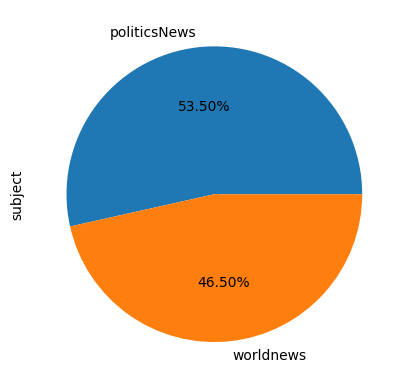

In [15]:
df_fake.subject.value_counts().plot(kind = "pie", autopct = "%.2f%%")

##### * From this pie charts we can find that the subjects are not divided equally

In [16]:
# Concatinating True data and fake data
df = pd.concat([df_fake, df_true])
df = shuffle(df)

In [17]:
df

,title,text,subject,date,reaction
3660,Tillerson: Trump is ready to engage personally...,TEL AVIV (Reuters) - U.S. Secretary of State R...,politicsNews,"May 22, 2017",1
10813,Republicans gear up for Supreme Court battle a...,WASHINGTON (Reuters) - Republican lawmakers an...,politicsNews,"February 14, 2016",1
20570,"Officials found list of targets with 5,000 nam...",BERLIN (Reuters) - German officials found list...,worldnews,"September 9, 2017",1
11786,TRUMP CHIEF OF STAFF Goes At It With Liberal H...,,politics,"Jan 29, 2017",0
17081,"Australian senate rejects proposed visa, citiz...",SYDNEY (Reuters) - Australia s lawmakers have ...,worldnews,"October 19, 2017",1
...,...,...,...,...,...
5085,WATCH: Trump Displays Wide Smirk As Heckler C...,"This truth doesn t hurt Donald Trump, it amuse...",News,"August 12, 2016",0
11942,Iran summons Swiss envoy over U.S.' 'irrespons...,ANKARA (Reuters) - Iran summoned the Swiss amb...,worldnews,"December 19, 2017",1
11604,BRAVE SWEDISH JOURNALISTS CONFIRM That Trump I...,SUBTITLED VIDEO:HERE S ANOTHER JOURNALIST S TA...,politics,"Feb 22, 2017",0
2685,Trump to nominate Huntsman as Russia ambassado...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"July 18, 2017",1


In [18]:
# Identifying the dates column which does not have date in it (Links)
dates = []
for i, date in enumerate(df.date):
  try:
    pd.to_datetime(date)
    continue
  except:
    dates.append(i)

In [19]:
dates

[695]

In [20]:
a = df.iloc[dates]

In [21]:
# Dropping the indexes which does not have date in it
df.drop(a.index, axis = 0, inplace = True)
df.reset_index(drop = 'index')

,title,text,subject,date,reaction
0,Tillerson: Trump is ready to engage personally...,TEL AVIV (Reuters) - U.S. Secretary of State R...,politicsNews,"May 22, 2017",1
1,Republicans gear up for Supreme Court battle a...,WASHINGTON (Reuters) - Republican lawmakers an...,politicsNews,"February 14, 2016",1
2,"Officials found list of targets with 5,000 nam...",BERLIN (Reuters) - German officials found list...,worldnews,"September 9, 2017",1
3,TRUMP CHIEF OF STAFF Goes At It With Liberal H...,,politics,"Jan 29, 2017",0
4,"Australian senate rejects proposed visa, citiz...",SYDNEY (Reuters) - Australia s lawmakers have ...,worldnews,"October 19, 2017",1
...,...,...,...,...,...
892,WATCH: Trump Displays Wide Smirk As Heckler C...,"This truth doesn t hurt Donald Trump, it amuse...",News,"August 12, 2016",0
893,Iran summons Swiss envoy over U.S.' 'irrespons...,ANKARA (Reuters) - Iran summoned the Swiss amb...,worldnews,"December 19, 2017",1
894,BRAVE SWEDISH JOURNALISTS CONFIRM That Trump I...,SUBTITLED VIDEO:HERE S ANOTHER JOURNALIST S TA...,politics,"Feb 22, 2017",0
895,Trump to nominate Huntsman as Russia ambassado...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"July 18, 2017",1


In [22]:
df['date'] = pd.to_datetime(df['date'])
for i in df['date']:
  datetime.datetime.strftime(i, '%y-%m')

In [23]:
true = df[df['reaction'] == 0]
fake = df[df['reaction'] == 1]

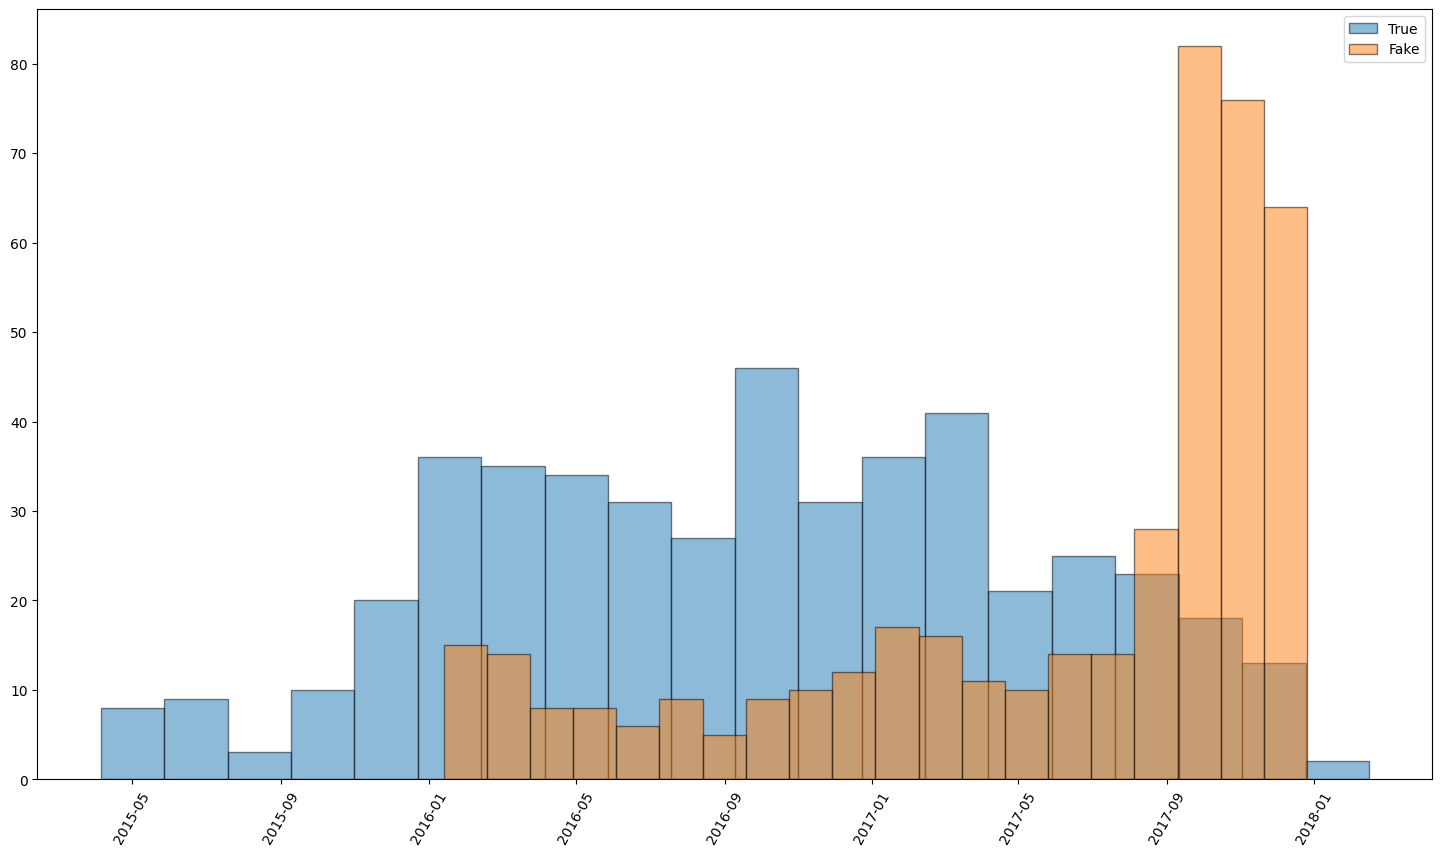

In [24]:
plt.figure(figsize = (18, 10))
plt.hist(true['date'], alpha = 0.5, bins = 20,edgecolor = 'black', label = 'True')
plt.hist(fake['date'], alpha = 0.5, bins = 20,edgecolor = 'black', label = 'Fake')
plt.xticks(rotation = 60)
plt.legend(loc = 'best')
plt.show()

In [25]:
df.drop(columns = ["date", "subject"], axis = 1, inplace = True)

In [26]:
df

,title,text,reaction
3660,Tillerson: Trump is ready to engage personally...,TEL AVIV (Reuters) - U.S. Secretary of State R...,1
10813,Republicans gear up for Supreme Court battle a...,WASHINGTON (Reuters) - Republican lawmakers an...,1
20570,"Officials found list of targets with 5,000 nam...",BERLIN (Reuters) - German officials found list...,1
11786,TRUMP CHIEF OF STAFF Goes At It With Liberal H...,,0
17081,"Australian senate rejects proposed visa, citiz...",SYDNEY (Reuters) - Australia s lawmakers have ...,1
...,...,...,...
5085,WATCH: Trump Displays Wide Smirk As Heckler C...,"This truth doesn t hurt Donald Trump, it amuse...",0
11942,Iran summons Swiss envoy over U.S.' 'irrespons...,ANKARA (Reuters) - Iran summoned the Swiss amb...,1
11604,BRAVE SWEDISH JOURNALISTS CONFIRM That Trump I...,SUBTITLED VIDEO:HERE S ANOTHER JOURNALIST S TA...,0
2685,Trump to nominate Huntsman as Russia ambassado...,WASHINGTON (Reuters) - U.S. President Donald T...,1


In [27]:
df.reset_index(inplace = True, drop = True)

In [28]:
df.isnull().sum()

title       0
text        0
reaction    0
dtype: int64

### Removing duplicates and empty columns

In [29]:
df["title"][0]

'Tillerson: Trump is ready to engage personally in Middle East peace'

In [30]:
df["title"].describe()

count                                                   897
unique                                                  894
top       ELIZABETH WARREN FREAKS After TRUMP REFERS To ...
freq                                                      2
Name: title, dtype: object

In [31]:
# Finding duplicates in title
df["title"].duplicated().sum()

3

In [32]:
# dropping the duplicates in title
df.drop_duplicates(subset = "title",inplace = True)

In [33]:
df.shape

(894, 3)

In [34]:
# Finding duplicates in text
df["text"].duplicated().sum()

9

In [35]:
# dropping the duplicates in text
df.drop_duplicates(subset = "text",inplace = True)

In [36]:
df.shape

(885, 3)

In [37]:
# finding any empty cell in title and text
empty = []
for i, title in enumerate(df.title):
    if len(title.split( )) == 0:
        empty.append(i)
    else:
        continue
for i, text in enumerate(df.text):
    if len(text.split( )) == 0:
        empty.append(i)
    else:
        continue

In [38]:
# dropping the empty cells
df.drop(labels = empty, axis = 0, inplace = True)
df.reset_index(drop = 'index', inplace = True)

In [39]:
df.shape

(884, 3)

0    456
1    428
Name: reaction, dtype: int64


<Axes: xlabel='reaction', ylabel='count'>

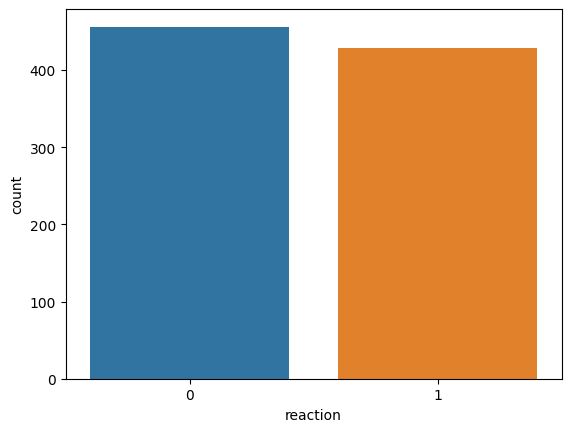

In [40]:
# number of real and fake news in the data
print(df["reaction"].value_counts())
sns.countplot(x = "reaction", data = df)

In [41]:
# Merging both title and text
df["text"] = df["title"] + " " + df["text"]
df.drop(columns = ["title"], axis = 1, inplace = True)

In [42]:
df

,text,reaction
0,Tillerson: Trump is ready to engage personally...,1
1,Republicans gear up for Supreme Court battle a...,1
2,"Officials found list of targets with 5,000 nam...",1
3,"Australian senate rejects proposed visa, citiz...",1
4,"BLACK FELON Brutally Beats Girlfriend, Grabs C...",0
...,...,...
879,WATCH: Trump Displays Wide Smirk As Heckler C...,0
880,Iran summons Swiss envoy over U.S.' 'irrespons...,1
881,BRAVE SWEDISH JOURNALISTS CONFIRM That Trump I...,0
882,Trump to nominate Huntsman as Russia ambassado...,1


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      884 non-null    object
 1   reaction  884 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ KB


### Data preprocessing

In [ ]:
ps = PorterStemmer()

In [ ]:
def preprocessing(x):
   x = x.lower()
   x = x.strip()
   x = re.sub('[^a-z/.@ ]', '', x)
   x = x.split()
   x = [word for word in x if word not in set(stopwords.words('english'))]    # removing the stop words
   x = [ps.stem(word) for word in x]     # porter stemmer
   x = ' '.join(x)
   return x

In [ ]:
preprocessing(df["text"][5])

In [ ]:
# applying preprocessing
df["text"] = df["text"].apply(preprocessing)

In [ ]:
df["text"][3]

In [ ]:
# splitting the words in text
df["words"] = df["text"].apply(lambda x : x.split())

In [ ]:
df

## Finding the Frequent Words in Uni, Bi and Tri gram

In [ ]:
#Finding most frequent words and plotting it in bar chart
token_space = tokenize.WhitespaceTokenizer()
def frequent(text, column, quantity, n):
    all_words = " ".join([text for text in text[column]])
    # finding all the unique words and appending it to token_phrase
    token_phrase = token_space.tokenize(all_words)
    # Finding top 50 frequent bi grams
    frequent_series = (pd.Series(nltk.ngrams(token_phrase, n)).value_counts())[:quantity]
    # visualizing top 50 frequent bi grams
    frequent_series.sort_values(ascending = False).plot.bar(x = "word", y = "Frequency",color='blue',
                                                            figsize=(12, 8))
    plt.xticks(rotation = 60)
    # plt.ylim(100,300)

In [ ]:
#Finding most frequent words for finding common
def common(text, column, quantity, ngrams):
    all_words = " ".join([text for text in text[column]])
    # finding all the unique words and appending it to token_phrase
    token_phrase = token_space.tokenize(all_words)
#     words = ngrams(token_phrase)
#     frequency = nltk.FreqDist(token_phrase)
    # finding the frequency of the words for ngrams
    frequency = (pd.Series(nltk.ngrams(token_phrase, ngrams)).value_counts())[:quantity]

#     frequency = pd.DataFrame(frequency.most_common(50), columns=['Word', 'Frequency'])

    # converting series into data frame
    frequency = pd.DataFrame(frequency)
    frequency.reset_index(inplace = True)
    return frequency

### Unigram Frequent Words

In [ ]:
#Most frequent unigram words in real data
frequent(df[df["reaction"] ==0 ], "text", 50, 1)

In [ ]:
# Most frequent unigram words in fake data
frequent(df[df["reaction"] ==1 ], "text", 50, 1)

In [ ]:
# common words in True data for unigram
UniTrueCommon = common(df[df["reaction"] ==0 ], "text", 50, 1)
UniTrueCommon

In [ ]:
# common words in Fake data for unigram
UniFakeCommon = common(df[df["reaction"] ==1 ], "text", 50, 1)
UniFakeCommon

In [ ]:
# common words in both true and fake data for Unigram
UniWordsCommon = dict(nltk.FreqDist(list(UniTrueCommon["index"]) + list(UniFakeCommon["index"])))
UniWordsCommon

In [ ]:
# unique words for uni gram
UniqueUni = []
for x, y in UniWordsCommon.items():
    if y == 1:
        UniqueUni.append(x)
print("Number of uniquie Unigram words :", len(UniqueUni))
UniqueUni

Number of uniquie Unigram words : 48


[('u.s.',),
 ('reuter',),
 ('said.',),
 ('govern',),
 ('unit',),
 ('senat',),
 ('parti',),
 ('offici',),
 ('told',),
 ('last',),
 ('countri',),
 ('includ',),
 ('washington',),
 ('two',),
 ('court',),
 ('secur',),
 ('leader',),
 ('north',),
 ('former',),
 ('group',),
 ('plan',),
 ('polit',),
 ('minist',),
 ('tax',),
 ('like',),
 ('obama',),
 ('time',),
 ('go',),
 ('get',),
 ('american',),
 ('video',),
 ('make',),
 ('hillari',),
 ('imag',),
 ('even',),
 ('news',),
 ('us',),
 ('use',),
 ('know',),
 ('right',),
 ('want',),
 ('via',),
 ('take',),
 ('think',),
 ('media',),
 ('come',),
 ('show',),
 ('first',)]

In [ ]:
# Common words for uni gram
CommonUni = []
for x, y in UniWordsCommon.items():
    if y == 2:
        CommonUni.append(x)
print("Number of common Unigram words :", len(CommonUni))
CommonUni

Number of common Unigram words : 26


[('said',),
 ('trump',),
 ('state',),
 ('would',),
 ('presid',),
 ('republican',),
 ('.',),
 ('say',),
 ('hous',),
 ('new',),
 ('democrat',),
 ('also',),
 ('year',),
 ('peopl',),
 ('nation',),
 ('could',),
 ('elect',),
 ('one',),
 ('support',),
 ('call',),
 ('vote',),
 ('campaign',),
 ('report',),
 ('donald',),
 ('white',),
 ('clinton',)]

In [ ]:
CommonUni=[i[0] for i in CommonUni]

In [ ]:
CommonUni

['said',
 'trump',
 'state',
 'would',
 'presid',
 'republican',
 '.',
 'say',
 'hous',
 'new',
 'democrat',
 'also',
 'year',
 'peopl',
 'nation',
 'could',
 'elect',
 'one',
 'support',
 'call',
 'vote',
 'campaign',
 'report',
 'donald',
 'white',
 'clinton']

In [ ]:
df["text"][5]

'republican surrend trump fear histor loss senat hous washington post report republican billionair less write white hous total loss rush hold onto hous senate. afraid good reason donald trump becom republican nomine go crush badli gener elect deliv chamber congress democrat partyth effort driven major player koch brother polit network alreadi begun lay groundwork colorado ohio pennsylvania along crossroad organ u.s. chamber commerce.th behemoth koch oper aim spend almost million novemb elect consid abandon trump nomine focus resourc behalf gop congression candidates.mi colleagu kori beth brown wrote trump put heavili gerrymand hous play move gop donor class confirm trump lead republican parti elector annihilation.hoorayaccord wapo instead dump billion dollar win white hous koch fellow oligarch plan spend money keep alreadi havea key element strategi springtim wave televis ad slam democrat contend tout republican incumb attun hometown concerns. strategist hope effort help inocul congres

In [ ]:
# Removing the common words from the corpus
def remove_commonWords_uni(x) :
    x = x.split()
    x = [word for word in x if word not in CommonUni]
    x = ' '.join(x)
    return x

In [ ]:
df["text"] = df["text"].apply(remove_commonWords_uni)

### Bigram Frequent Words

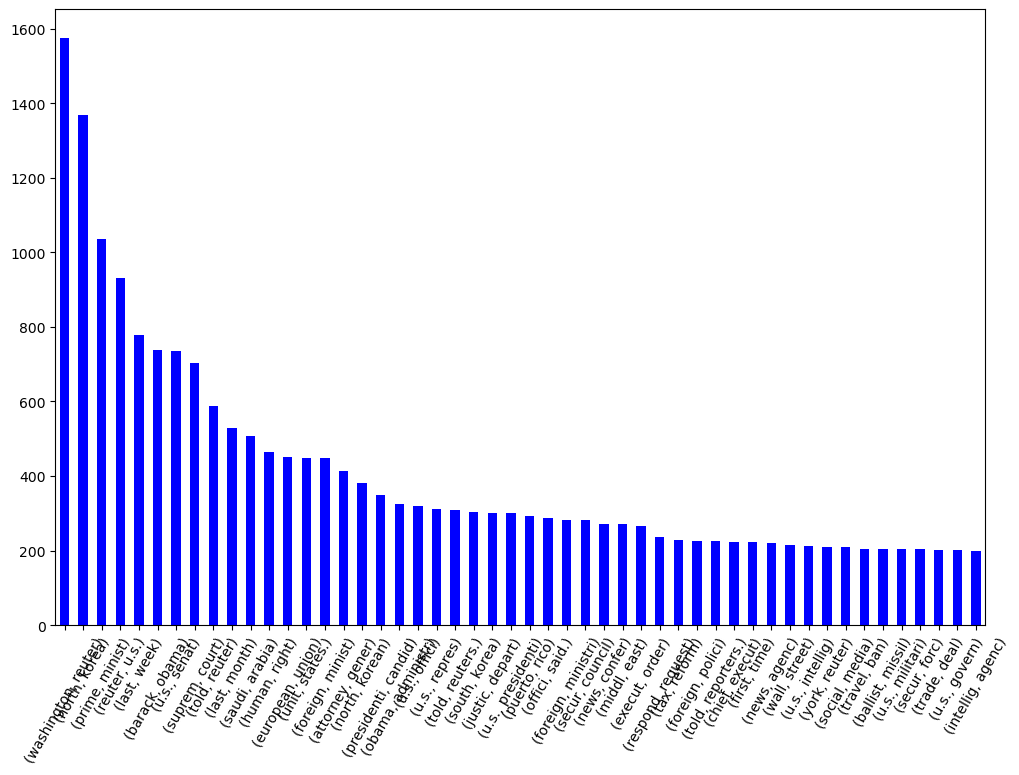

In [ ]:
# Most frequent bigram words in real data
frequent(df[df["reaction"] ==0 ], "text", 50, 2)

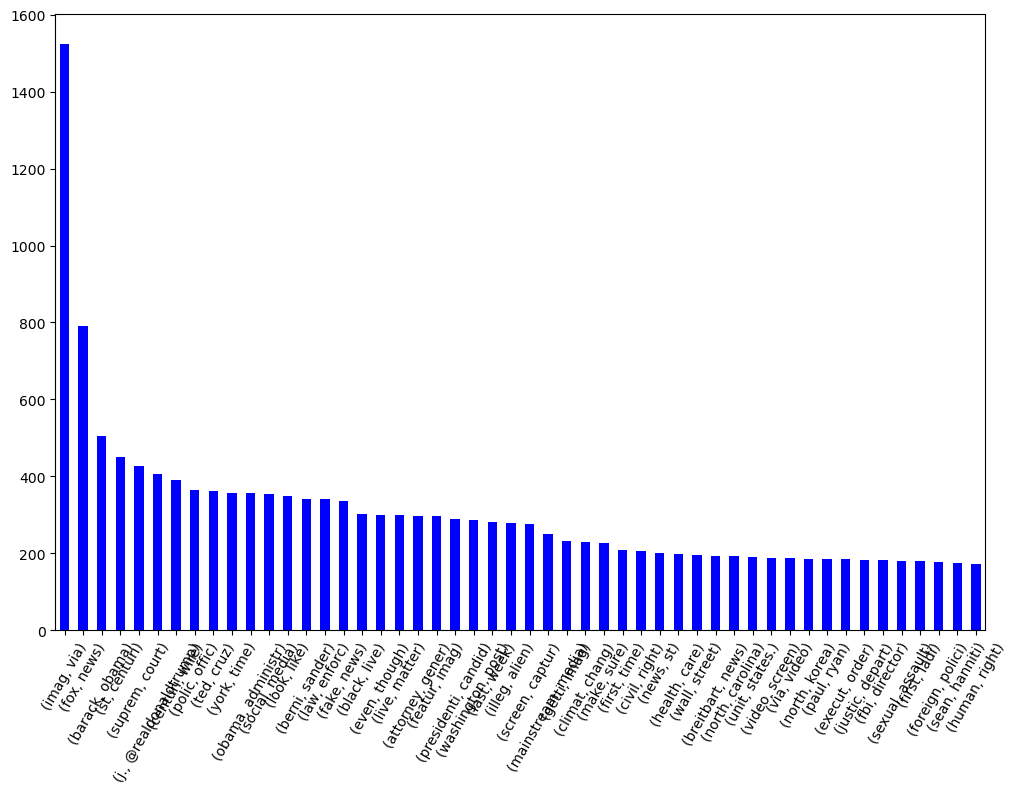

In [ ]:
# Most frequent bigram words in fake data
frequent(df[df["reaction"] ==1 ], "text", 50, 2)

In [ ]:
# common words in true data for Bigram
BiTrueCommon = common(df[df["reaction"] ==0 ], "text", 50, 2)
BiTrueCommon

,index,0
0,"(washington, reuter)",1574
1,"(north, korea)",1369
2,"(prime, minist)",1035
3,"(reuter, u.s.)",931
4,"(last, week)",778
5,"(barack, obama)",738
6,"(u.s., senat)",735
7,"(suprem, court)",702
8,"(told, reuter)",588
9,"(last, month)",529


In [ ]:
# common words in fake data for Bigram
BiFakeCommon = common(df[df["reaction"] ==1 ], "text", 50, 2)
BiFakeCommon

,index,0
0,"(imag, via)",1525
1,"(fox, news)",792
2,"(barack, obama)",505
3,"(st, centuri)",449
4,"(suprem, court)",426
5,"(j., @realdonaldtrump)",407
6,"(centuri, wire)",390
7,"(polic, offic)",365
8,"(ted, cruz)",361
9,"(york, time)",357


In [ ]:
# common words in both true and fake data for Bigram
BiWordsCommon = dict(nltk.FreqDist(list(BiTrueCommon["index"]) + list(BiFakeCommon["index"])))
BiWordsCommon

{('washington', 'reuter'): 1,
 ('north', 'korea'): 2,
 ('prime', 'minist'): 1,
 ('reuter', 'u.s.'): 1,
 ('last', 'week'): 2,
 ('barack', 'obama'): 2,
 ('u.s.', 'senat'): 1,
 ('suprem', 'court'): 2,
 ('told', 'reuter'): 1,
 ('last', 'month'): 1,
 ('saudi', 'arabia'): 1,
 ('human', 'right'): 2,
 ('european', 'union'): 1,
 ('unit', 'states.'): 2,
 ('foreign', 'minist'): 1,
 ('attorney', 'gener'): 2,
 ('north', 'korean'): 1,
 ('presidenti', 'candid'): 2,
 ('obama', 'administr'): 2,
 ('u.s.', 'offici'): 1,
 ('u.s.', 'repres'): 1,
 ('told', 'reuters.'): 1,
 ('south', 'korea'): 1,
 ('justic', 'depart'): 2,
 ('u.s.', 'presidenti'): 1,
 ('puerto', 'rico'): 1,
 ('offici', 'said.'): 1,
 ('foreign', 'ministri'): 1,
 ('secur', 'council'): 1,
 ('news', 'confer'): 1,
 ('middl', 'east'): 1,
 ('execut', 'order'): 2,
 ('respond', 'request'): 1,
 ('tax', 'reform'): 1,
 ('foreign', 'polici'): 2,
 ('told', 'reporters.'): 1,
 ('chief', 'execut'): 1,
 ('first', 'time'): 2,
 ('news', 'agenc'): 1,
 ('wall', 's

In [ ]:
# unique words for bi gram
UniqueBi = []
for x, y in BiWordsCommon.items():
    if y == 1:
        UniqueBi.append(x)
print("Number of uniquie Bigram words :", len(UniqueBi))
UniqueBi

Number of uniquie Bigram words : 70


[('washington', 'reuter'),
 ('prime', 'minist'),
 ('reuter', 'u.s.'),
 ('u.s.', 'senat'),
 ('told', 'reuter'),
 ('last', 'month'),
 ('saudi', 'arabia'),
 ('european', 'union'),
 ('foreign', 'minist'),
 ('north', 'korean'),
 ('u.s.', 'offici'),
 ('u.s.', 'repres'),
 ('told', 'reuters.'),
 ('south', 'korea'),
 ('u.s.', 'presidenti'),
 ('puerto', 'rico'),
 ('offici', 'said.'),
 ('foreign', 'ministri'),
 ('secur', 'council'),
 ('news', 'confer'),
 ('middl', 'east'),
 ('respond', 'request'),
 ('tax', 'reform'),
 ('told', 'reporters.'),
 ('chief', 'execut'),
 ('news', 'agenc'),
 ('u.s.', 'intellig'),
 ('york', 'reuter'),
 ('travel', 'ban'),
 ('ballist', 'missil'),
 ('u.s.', 'militari'),
 ('secur', 'forc'),
 ('trade', 'deal'),
 ('u.s.', 'govern'),
 ('intellig', 'agenc'),
 ('imag', 'via'),
 ('fox', 'news'),
 ('st', 'centuri'),
 ('j.', '@realdonaldtrump'),
 ('centuri', 'wire'),
 ('polic', 'offic'),
 ('ted', 'cruz'),
 ('york', 'time'),
 ('look', 'like'),
 ('berni', 'sander'),
 ('law', 'enforc'),

In [ ]:
# Common words for Bi gram
CommonBi1 = []
for x, y in BiWordsCommon.items():
    if y == 2:
        CommonBi1.append(x)
print("Number of common Bigram words :",len(CommonBi1))
CommonBi1

Number of common Bigram words : 15


[('north', 'korea'),
 ('last', 'week'),
 ('barack', 'obama'),
 ('suprem', 'court'),
 ('human', 'right'),
 ('unit', 'states.'),
 ('attorney', 'gener'),
 ('presidenti', 'candid'),
 ('obama', 'administr'),
 ('justic', 'depart'),
 ('execut', 'order'),
 ('foreign', 'polici'),
 ('first', 'time'),
 ('wall', 'street'),
 ('social', 'media')]

In [ ]:
CommonBi=[]
for i in CommonBi1 :
    CommonBi.append(i[0])
    CommonBi.append(i[1])

In [ ]:
CommonBi

['north',
 'korea',
 'last',
 'week',
 'barack',
 'obama',
 'suprem',
 'court',
 'human',
 'right',
 'unit',
 'states.',
 'attorney',
 'gener',
 'presidenti',
 'candid',
 'obama',
 'administr',
 'justic',
 'depart',
 'execut',
 'order',
 'foreign',
 'polici',
 'first',
 'time',
 'wall',
 'street',
 'social',
 'media']

In [ ]:
# Removing the common Bigram words from the corpus
def remove_commonWords_bi(x) :
    x = x.split()
    x = [word for word in x if word not in CommonBi]
    x = ' '.join(x)
    return x

In [ ]:
df["text"] = df["text"].apply(remove_commonWords_bi)

### Trigram Frequent Words

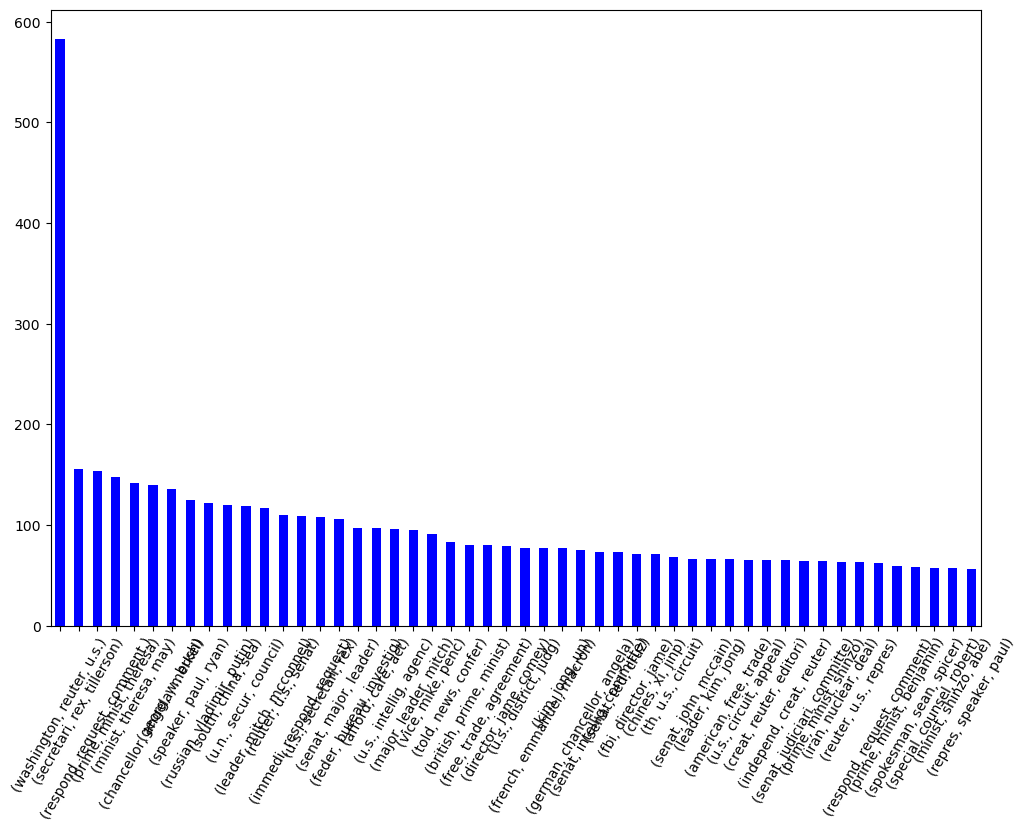

In [ ]:
# Most frequent trigram words in real data
frequent(df[df["reaction"] ==0 ], "text", 50, 3)

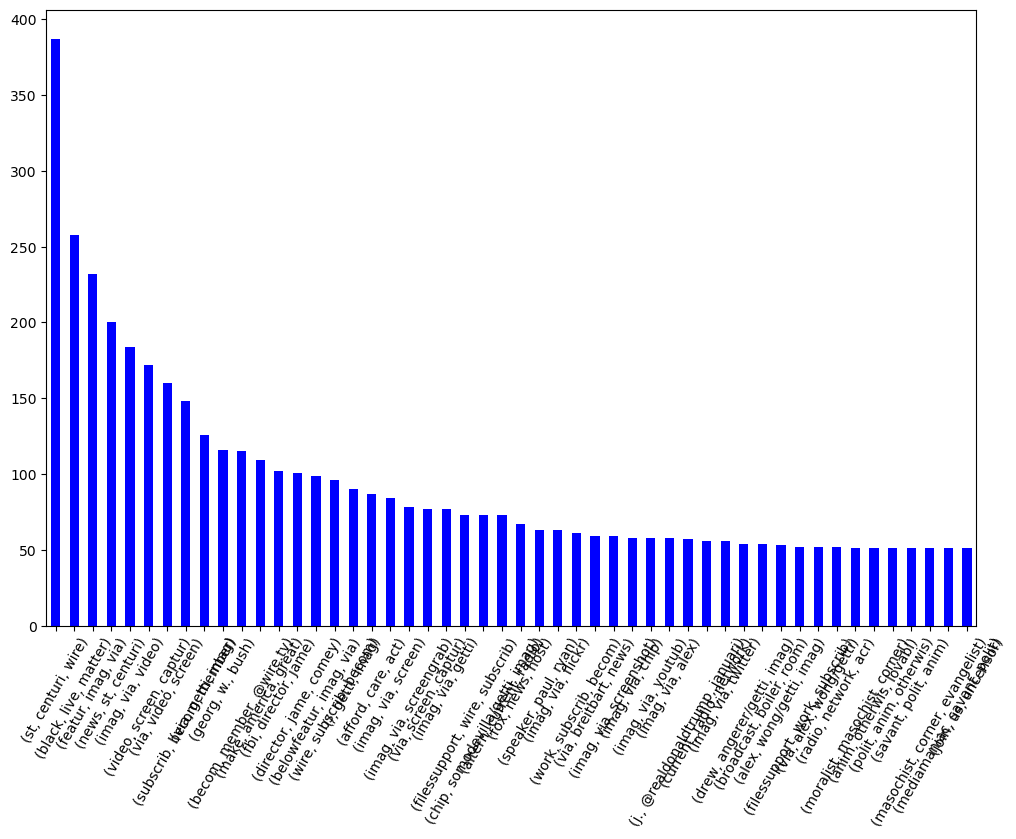

In [ ]:
# Most frequent trigram words in real data
frequent(df[df["reaction"] ==1 ], "text", 50, 3)

In [ ]:
# common words in true data for Trigram
TriTrueCommon = common(df[df["reaction"] ==0 ], "text", 50, 3)
TriTrueCommon

,index,0
0,"(washington, reuter, u.s.)",583
1,"(secretari, rex, tillerson)",156
2,"(respond, request, comment.)",154
3,"(prime, minist, theresa)",148
4,"(minist, theresa, may)",142
5,"(chancellor, angela, merkel)",140
6,"(georg, w., bush)",136
7,"(speaker, paul, ryan)",125
8,"(russian, vladimir, putin)",122
9,"(south, china, sea)",120


In [ ]:
# common words in both true and fake data for Trigram
TriFakeCommon = common(df[df["reaction"] ==1 ], "text", 50, 3)
TriFakeCommon

,index,0
0,"(st, centuri, wire)",387
1,"(black, live, matter)",258
2,"(featur, imag, via)",232
3,"(news, st, centuri)",200
4,"(imag, via, video)",184
5,"(video, screen, captur)",172
6,"(via, video, screen)",160
7,"(subscrib, becom, member)",148
8,"(via, getti, imag)",126
9,"(georg, w., bush)",116


In [ ]:
# common words in both true and fake data for Trigram
TriWordsCommon = dict(nltk.FreqDist(list(TriTrueCommon["index"]) + list(TriFakeCommon["index"])))
TriWordsCommon

{('washington', 'reuter', 'u.s.'): 1,
 ('secretari', 'rex', 'tillerson'): 1,
 ('respond', 'request', 'comment.'): 1,
 ('prime', 'minist', 'theresa'): 1,
 ('minist', 'theresa', 'may'): 1,
 ('chancellor', 'angela', 'merkel'): 1,
 ('georg', 'w.', 'bush'): 2,
 ('speaker', 'paul', 'ryan'): 2,
 ('russian', 'vladimir', 'putin'): 1,
 ('south', 'china', 'sea'): 1,
 ('u.n.', 'secur', 'council'): 1,
 ('leader', 'mitch', 'mcconnel'): 1,
 ('reuter', 'u.s.', 'senat'): 1,
 ('immedi', 'respond', 'request'): 1,
 ('u.s.', 'secretari', 'rex'): 1,
 ('senat', 'major', 'leader'): 1,
 ('feder', 'bureau', 'investig'): 1,
 ('afford', 'care', 'act'): 2,
 ('u.s.', 'intellig', 'agenc'): 1,
 ('major', 'leader', 'mitch'): 1,
 ('vice', 'mike', 'penc'): 1,
 ('told', 'news', 'confer'): 1,
 ('british', 'prime', 'minist'): 1,
 ('free', 'trade', 'agreement'): 1,
 ('director', 'jame', 'comey'): 2,
 ('french', 'emmanuel', 'macron'): 1,
 ('kim', 'jong', 'un'): 1,
 ('u.s.', 'district', 'judg'): 1,
 ('german', 'chancellor', '

In [ ]:
# unique words for Tri gram
UniqueTri = []
for x, y in TriWordsCommon.items():
    if y == 1:
        UniqueTri.append(x)
print("Number of uniquie Trigram words :", len(UniqueTri))
UniqueTri

Number of uniquie Trigram words : 90


[('washington', 'reuter', 'u.s.'),
 ('secretari', 'rex', 'tillerson'),
 ('respond', 'request', 'comment.'),
 ('prime', 'minist', 'theresa'),
 ('minist', 'theresa', 'may'),
 ('chancellor', 'angela', 'merkel'),
 ('russian', 'vladimir', 'putin'),
 ('south', 'china', 'sea'),
 ('u.n.', 'secur', 'council'),
 ('leader', 'mitch', 'mcconnel'),
 ('reuter', 'u.s.', 'senat'),
 ('immedi', 'respond', 'request'),
 ('u.s.', 'secretari', 'rex'),
 ('senat', 'major', 'leader'),
 ('feder', 'bureau', 'investig'),
 ('u.s.', 'intellig', 'agenc'),
 ('major', 'leader', 'mitch'),
 ('vice', 'mike', 'penc'),
 ('told', 'news', 'confer'),
 ('british', 'prime', 'minist'),
 ('free', 'trade', 'agreement'),
 ('french', 'emmanuel', 'macron'),
 ('kim', 'jong', 'un'),
 ('u.s.', 'district', 'judg'),
 ('german', 'chancellor', 'angela'),
 ('senat', 'intellig', 'committe'),
 ('senat', 'ted', 'cruz'),
 ('chines', 'xi', 'jinp'),
 ('th', 'u.s.', 'circuit'),
 ('senat', 'john', 'mccain'),
 ('leader', 'kim', 'jong'),
 ('american', 

In [ ]:
# Common words for uni gram
CommonTri1 = []
for x, y in TriWordsCommon.items():
    if y == 2:
        CommonTri1.append(x)
print("Number of common Trigram words :",len(CommonTri1))
CommonTri1

Number of common Trigram words : 5


[('georg', 'w.', 'bush'),
 ('speaker', 'paul', 'ryan'),
 ('afford', 'care', 'act'),
 ('director', 'jame', 'comey'),
 ('fbi', 'director', 'jame')]

In [ ]:
CommonTri=[]
for i in CommonTri1 :
    CommonTri.append(i[0])
    CommonTri.append(i[1])
    CommonTri.append(i[2])

In [ ]:
CommonTri

['georg',
 'w.',
 'bush',
 'speaker',
 'paul',
 'ryan',
 'afford',
 'care',
 'act',
 'director',
 'jame',
 'comey',
 'fbi',
 'director',
 'jame']

In [ ]:
# Removing the common Trigram words from the corpus
def remove_commonWords_tri(x) :
    x = x.split()
    x = [word for word in x if word not in CommonTri]
    x = ' '.join(x)
    return x

In [ ]:
df["text"] = df["text"].apply(remove_commonWords_tri)

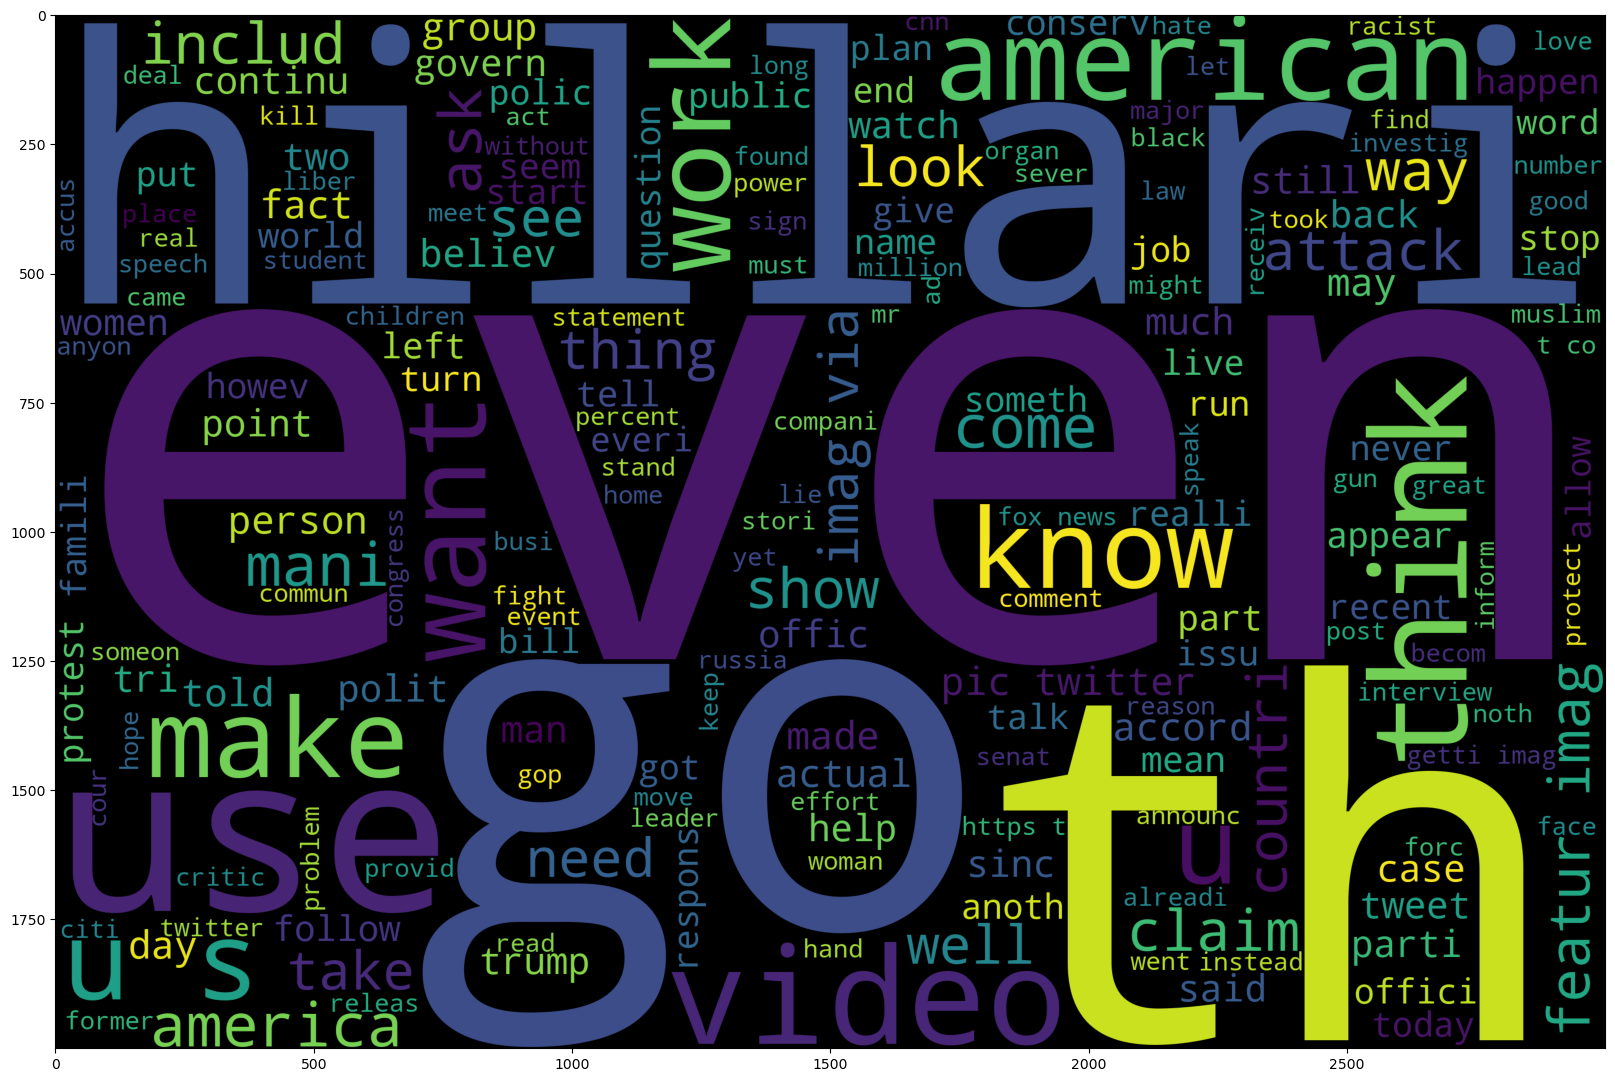

In [ ]:
# visualizing the most frequent words for fake data by using word cloud
wordcloud = WordCloud(width=3000, height= 2000).generate(" ".join(df[df.reaction == 1].text))
plt.figure(figsize=(20,20))
plt.imshow(wordcloud)

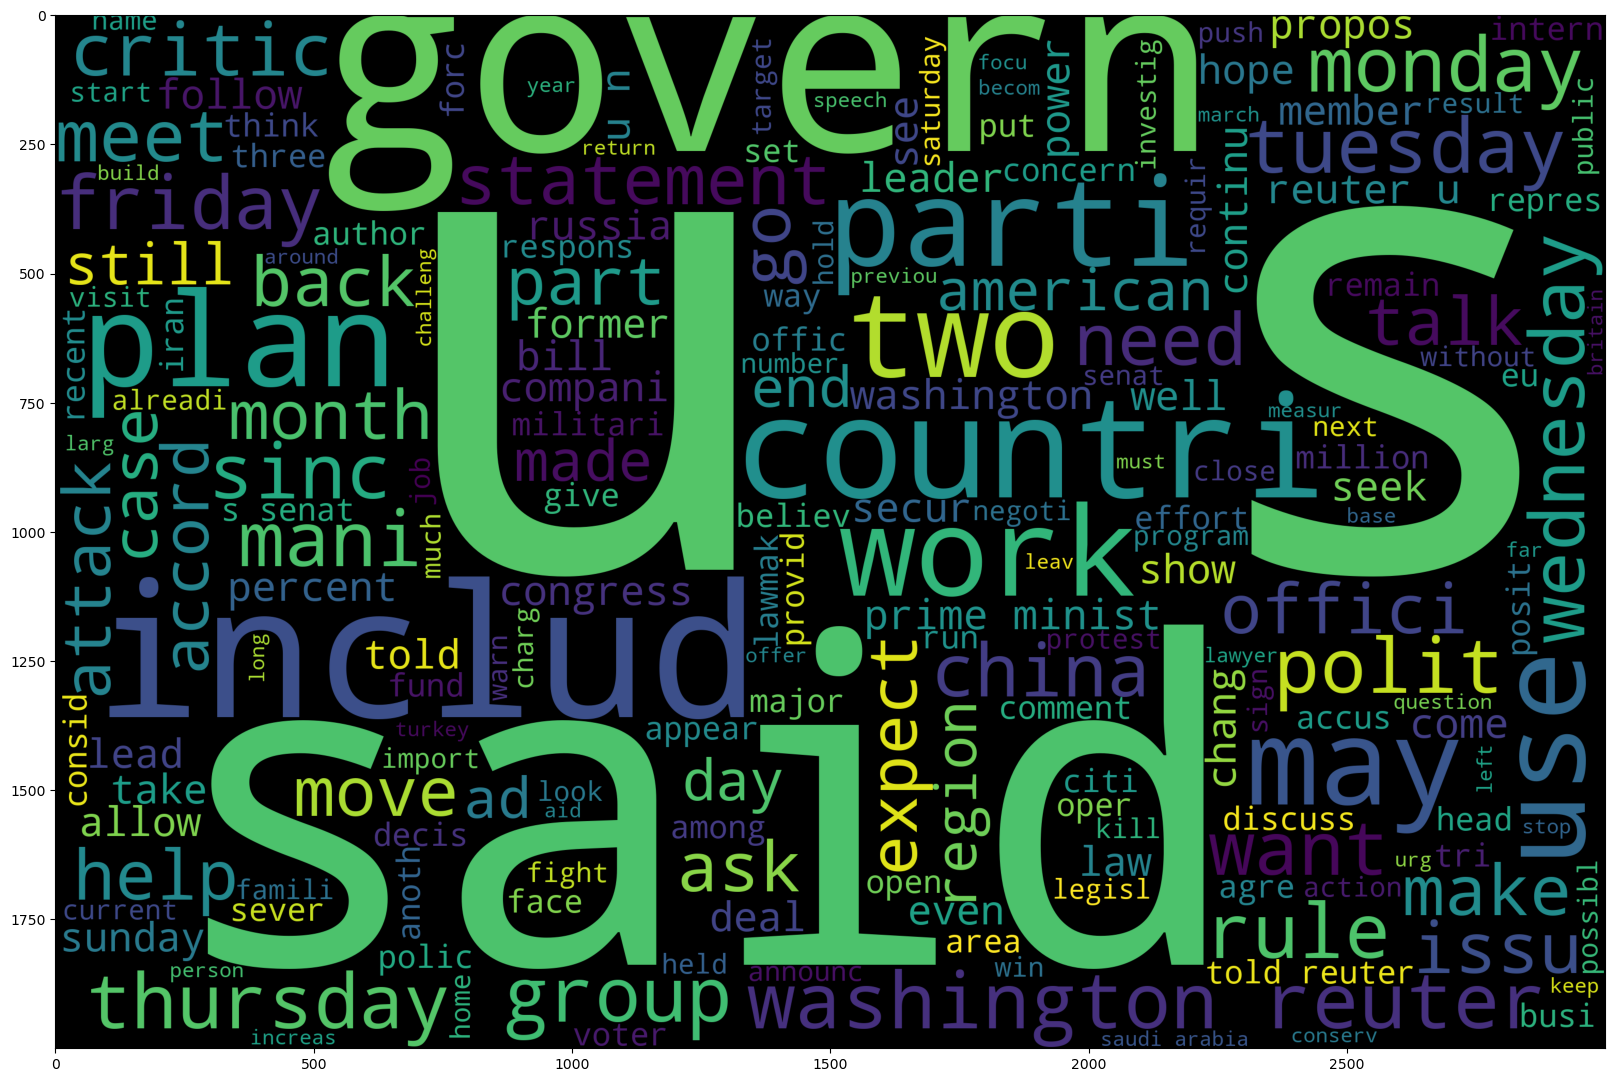

In [ ]:
# visualizing the most frequent words for real data by using word cloud
wordcloud = WordCloud(width=3000, height= 2000).generate(" ".join(df[df.reaction == 0].text))
plt.figure(figsize=(20,20))
plt.imshow(wordcloud)

### Feature Engineering

In [ ]:
df.text.values

array(['blast refus hand voter data washington reuter lash saturday grow number refus give voter name address sensit person inform commiss creat investig alleg voter fraud. numer refus give inform distinguish voter fraud panel wrote twitter. tri hide includ virginia kentucki california york massachusett declin provid inform unnecessari violat privacy. commiss form tri find basi lie put forward foundat kentucki secretari alison lundergan grime told reuter previous interview. made unsubstanti claim million illeg rival hillari novemb election. advisori commiss integr creat may sent letter ask turn voter inform includ name four digit secur number address birth date polit affili feloni convict histories. request commiss vice chairman kri kobach caus backlash officials. indiana secretari conni lawson statement friday certain voter inform avail public person request inform inform restrict name address congression district assignment. mississippi secretari delbert hosemann statement see letter

In [ ]:
cv = TfidfVectorizer(ngram_range=(1,2), max_features=2000)
X = cv.fit_transform(df.text.values).toarray()
X=pd.DataFrame(X,columns=cv.get_feature_names())

In [ ]:
cv.vocabulary_

{'blast': 204,
 'refus': 1465,
 'hand': 784,
 'voter': 1921,
 'data': 449,
 'washington': 1932,
 'reuter': 1520,
 'saturday': 1565,
 'grow': 771,
 'number': 1210,
 'give': 746,
 'name': 1170,
 'address': 28,
 'sensit': 1607,
 'person': 1307,
 'inform': 888,
 'commiss': 352,
 'creat': 428,
 'investig': 913,
 'alleg': 64,
 'fraud': 715,
 'numer': 1211,
 'panel': 1270,
 'wrote': 1986,
 'twitter': 1870,
 'tri': 1851,
 'includ': 875,
 'virginia': 1914,
 'california': 248,
 'york': 1995,
 'declin': 466,
 'provid': 1400,
 'violat': 1911,
 'form': 702,
 'find': 679,
 'basi': 166,
 'lie': 1025,
 'put': 1414,
 'forward': 706,
 'foundat': 709,
 'secretari': 1587,
 'told': 1820,
 'previous': 1362,
 'interview': 910,
 'made': 1058,
 'claim': 321,
 'million': 1128,
 'illeg': 855,
 'rival': 1539,
 'hillari': 818,
 'novemb': 1206,
 'election': 564,
 'integr': 899,
 'may': 1087,
 'sent': 1608,
 'letter': 1020,
 'ask': 126,
 'turn': 1867,
 'four': 711,
 'secur': 1590,
 'birth': 199,
 'date': 450,
 'poli

In [ ]:
X

,abandon,abc,abe,abil,abl,abort,abroad,absolut,abus,accept,...,yearold,years,yemen,yesterday,yet,york,you,young,youtub,zone
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.049038,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.056334,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10655,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.091504,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
10656,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
10657,0.0,0.037926,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.037861,0.000000,0.000000,0.000000,0.0,0.0,0.0
10658,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.140311,0.018686,0.054144,0.027338,0.0,0.0,0.0


In [ ]:
# splitting the data set to train and test
X_train, X_test, y_train, y_test = train_test_split(X, df.reaction,
                                                    stratify=df.reaction, test_size= 0.2, random_state=6)

In [ ]:
X_train

,abandon,abc,abe,abil,abl,abort,abroad,absolut,abus,accept,...,yearold,years,yemen,yesterday,yet,york,you,young,youtub,zone
1463,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4877,0.0,0.0,0.120502,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
7701,0.0,0.0,0.000000,0.0,0.026000,0.0,0.0,0.058753,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.023775,0.000000,0.034784,0.000000,0.0,0.0
8393,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.079730,0.000000,0.000000,...,0.147986,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
10007,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.049005,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9215,0.0,0.0,0.000000,0.0,0.078958,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.172876,0.0,0.0
631,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.046638,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2295,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.059926,0.0,0.0,0.0,0.000000,0.050476,0.000000,0.000000,0.0,0.0
4939,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.059268,...,0.000000,0.0,0.0,0.0,0.050323,0.000000,0.000000,0.000000,0.0,0.0


In [ ]:
# Applying Multinomial Naive Bayes
pipe = Pipeline([("Naive",MultinomialNB())
                ])
# Fitting the model
Naive_model = pipe.fit(X_train,y_train)

y_pred = Naive_model.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1061
           1       0.94      0.93      0.93      1071

    accuracy                           0.93      2132
   macro avg       0.93      0.93      0.93      2132
weighted avg       0.93      0.93      0.93      2132



In [ ]:
# Applying Decision tree
pipe = Pipeline([("DecisionTree",DecisionTreeClassifier())
                ])
# Fitting the model
Decision_model = pipe.fit(X_train,y_train)

y_pred = Decision_model.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1061
           1       1.00      0.99      0.99      1071

    accuracy                           0.99      2132
   macro avg       0.99      0.99      0.99      2132
weighted avg       0.99      0.99      0.99      2132



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=10)
print(scores)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


[0.99062134 0.99413834 0.99413834 0.99531067 0.989449   0.99179367
 0.996483   0.99179367 0.99061033 0.99178404]
Accuracy: 0.99 (+/- 0.00)


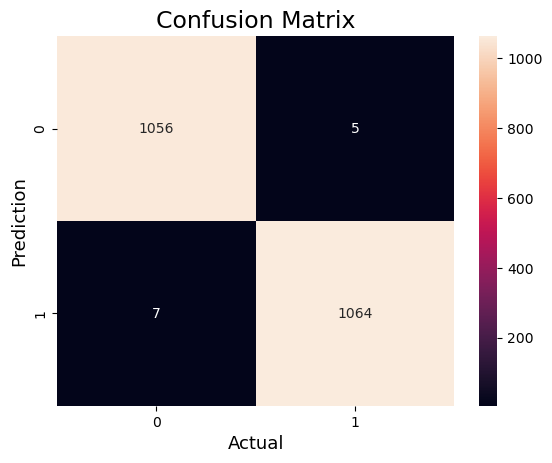

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm,
            annot=True,
            fmt='g',
        )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

### Prediction

In [ ]:
sentence = [" Don't worry if you don't understand",
                      " Racist Alabama Cops Brutalize Black Boy While He Is In Handcuffs (GRAPHIC IMAGES)"]

In [ ]:
process = [preprocessing(n) for n in sentence]

In [ ]:
process

['dont worri dont understand',
 'racist alabama cop brutal black boy handcuff graphic imag']

In [ ]:
process = np.array(process)

In [ ]:
 cv.fit_transform(process)

<2x23 sparse matrix of type '<class 'numpy.float64'>'
	with 23 stored elements in Compressed Sparse Row format>

In [ ]:
Decision_model.predict(Y)

ValueError: X has 23 features, but DecisionTreeClassifier is expecting 2000 features as input.

## Deploying the Code using StreamLit

In [ ]:
dump(Decision_model, open('Decision.sav', 'wb'))
dump(preprocessing, open('preprocessing.sav', 'wb'))

In [ ]:
import pickle

In [ ]:
with open('news_classifier', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
!streamlit run news_classifier.py

# Using Spacy Word Library

### Feature Engineering

In [ ]:
import spacy.cli
nlp = spacy.load("en_core_web_lg")

In [ ]:
def similarity(base_word, word_to_compare):
    base_token = nlp(base_word)
    doc = nlp(word_to_compare)
    for token in doc:
        print(f"{token.text} - {base_token.text}", token.similarity(base_token))

In [ ]:
similarity("iphone","samsung bread phone laptop road")

samsung - iphone 0.670859081425417
bread - iphone 0.13758431689572845
phone - iphone 0.729336356768957
laptop - iphone 0.6639642225896586
road - iphone 0.1254580392569915


In [ ]:
df["vector"] = df["text"].apply(lambda x: nlp(x).vector)

In [ ]:
df.head()

,text,reaction,words,vector
0,factbox britain whose leader post retweet lond...,0,"[factbox, britain, first, whose, leader, post,...","[-0.82200587, -0.16530327, -1.4223441, 0.09034..."
1,pay establish reward comey million book deal s...,1,"[pay, establish, reward, comey, million, book,...","[-0.28108287, 0.13287482, -1.4688827, -0.19738..."
2,danish diver find miss bodi part swedish journ...,0,"[danish, diver, find, miss, bodi, part, swedis...","[-0.28125197, -0.2729737, -1.0398815, -0.51058..."
3,lgbt commun make conserv go crazi video stun r...,1,"[trump, said, lgbt, commun, make, conserv, go,...","[-0.46995363, 0.5188954, -1.788102, -0.1500358..."
4,watch here happen publicist stephen colbert st...,1,"[watch, here, happen, trump, publicist, call, ...","[-0.08143368, -0.049099404, -1.1864018, -0.131..."


### model Building

In [ ]:
# splitting the data set to train and test
X_train, X_test, y_train, y_test = train_test_split(df.vector.values, df.reaction,
                                                    stratify=df.reaction, test_size= 0.2, random_state=6)

In [ ]:
X_train

array([array([-0.17061798,  0.65849596, -1.9766445 , -0.6169973 ,  1.8801684 ,
               0.7853375 ,  0.7742267 ,  2.2341514 , -1.5280547 ,  0.38859797,
               3.673332  ,  0.8805958 , -2.4866014 ,  1.6020094 ,  1.8065829 ,
               0.15068577,  1.0289241 , -1.6644714 , -0.80716103, -1.5073421 ,
               0.5558921 ,  0.14885664, -0.354342  , -1.7379293 , -1.1722467 ,
              -0.9505609 , -1.5038868 , -0.9962976 ,  0.21175982,  1.8399788 ,
               1.0991689 , -1.0110171 , -0.560889  , -1.8684828 , -0.30096698,
              -0.39201573, -0.23411341,  0.78663474,  2.0259287 ,  2.1834419 ,
              -0.38148186,  0.5025579 ,  1.0160494 , -0.478239  , -1.301406  ,
               0.8944965 ,  0.39803395, -2.2276652 , -0.46285078,  0.48143637,
              -0.11455712,  1.1869044 ,  0.36314252, -2.7577493 , -0.75364715,
               0.42308098, -0.5682156 ,  1.0532058 ,  0.88311595,  1.2526711 ,
               0.6888557 , -0.46789134, -1.2765851 ,

In [ ]:
# coverting to 2d numpy array
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [ ]:
X_train_2d

array([[-0.17061798,  0.65849596, -1.9766445 , ...,  0.48153195,
        -1.4656318 ,  0.44948998],
       [-0.33072397,  0.5261231 , -2.0741591 , ..., -0.73738587,
        -1.0195702 ,  0.61987585],
       [-0.6552588 ,  0.14328912, -1.839882  , ..., -0.40004286,
        -0.9325439 ,  0.63527286],
       ...,
       [-0.13288592,  0.04325218, -1.4287016 , ..., -0.38310656,
        -0.45569322,  0.4800628 ],
       [-0.54800117, -0.12778883, -1.617627  , ..., -0.2515898 ,
        -0.9350354 ,  0.3022846 ],
       [-0.63297117,  0.0634463 , -1.7498986 , ..., -0.45397756,
        -0.6321062 ,  0.3806107 ]], dtype=float32)

In [ ]:
# scaling the data
scalar = MinMaxScaler()
scaled_train = scalar.fit_transform(X_train_2d)
scaled_test = scalar.fit_transform(X_test_2d)

In [ ]:
# Applying Multinomial Naive Bayes
pipe = Pipeline([("model",MultinomialNB())

                ])
# Fitting the model
model = pipe.fit(scaled_train,y_train)

y_pred = model.predict(scaled_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      1061
           1       0.81      0.93      0.86      1071

    accuracy                           0.85      2132
   macro avg       0.86      0.85      0.85      2132
weighted avg       0.86      0.85      0.85      2132



In [ ]:
# Applying Multinomial Naive Bayes
pipe = Pipeline([("model",DecisionTreeClassifier())

                ])
# Fitting the model
model = pipe.fit(scaled_train,y_train)

y_pred = model.predict(scaled_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.66      0.70      1061
           1       0.69      0.77      0.73      1071

    accuracy                           0.71      2132
   macro avg       0.72      0.71      0.71      2132
weighted avg       0.72      0.71      0.71      2132



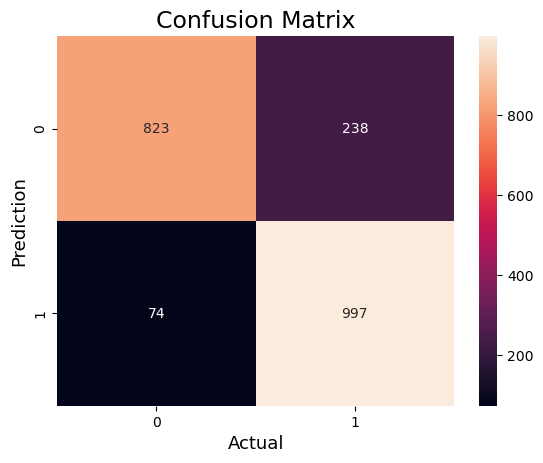

In [ ]:
cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm,
            annot=True,
            fmt='g',
        )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

# Using Hugging Face Tranformer

In [ ]:
pip install transformers tensorflow torch

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import torch
from transformers import TrainingArguments, Trainer

In [46]:
X = list(df["text"])
y = list(df["reaction"])
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,stratify=y)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [47]:
X_train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [48]:
len(X_train),len(X_val)

(707, 177)

In [49]:
import torch
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [52]:
train_dataset[2]

{'input_ids': tensor([  101,  8519,  1024,  8396,  3549,  2444,  2192,  2000,  2677,  2006,
         22410, 11980,  1998,  2037, 10403,  2524,  2147,  6285, 15544,  5753,
         18826,  1010, 14429,  2157,  1011,  3358,  9452,  1998,  9788,  2079,
         19140, 16078,  1010,  4510, 29552,  2015,  2011,  2006,  2010,  2231,
         11980,  4638,  1998,  2038,  2056,  2008,  2002,  2003, 18836,  2000,
          2031,  1037,  2564,  2040,  2573,  1012,  2004,  2009,  4332,  2041,
          1010,  8519,  2425,  2149,  2008,  2023,  3124,  2040, 15970,  2010,
          2420,  3554, 15344,  7465,  1998, 13475,  2039,  1037,  2204,  2158,
          1055,  7722,  3475,  1056,  1996,  6453,  2000,  1996, 28321,  2008,
          2191,  2039,  1037,  2157,  1011,  3358,  9452,  8396,  1010,  2002,
          1055,  1996,  6210,  1012,  2122,  4364,  2024,  3631,  1010,  2056,
          2928,  6770,  3540,  3567,  3351,  1010,  2040,  2038,  2042, 20059,
          2521,  1011,  2157,  5750,  2

In [ ]:
pip install evaluate

In [50]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [51]:
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=-1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [8]:
from transformers import AutoTokenizer, DataCollatorWithPadding
data_collator= DataCollatorWithPadding(tokenizer)

In [ ]:
! pip install -U accelerate
! pip install -U transformers

In [7]:
import torch
from transformers import TrainingArguments, Trainer

In [54]:
training_args = TrainingArguments(
    output_dir="output",          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
)

In [55]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [56]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=89, training_loss=0.10940296730298675, metrics={'train_runtime': 4872.3337, 'train_samples_per_second': 0.145, 'train_steps_per_second': 0.018, 'total_flos': 186019516139520.0, 'train_loss': 0.10940296730298675, 'epoch': 1.0})

In [57]:
trainer.evaluate()

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.037141866981983185,
 'eval_accuracy': 0.9943502824858758,
 'eval_precision': 1.0,
 'eval_recall': 0.9883720930232558,
 'eval_f1': 0.9941520467836257,
 'eval_runtime': 385.5456,
 'eval_samples_per_second': 0.459,
 'eval_steps_per_second': 0.06,
 'epoch': 1.0}

The Accuracy of the model using BERT transformer is 99.5%.

In [ ]:
trainer.save_model('SentimentTransformerModel')

In [6]:
model_2 = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/SentimentTransformerModel")

In [9]:
# Fake data
text = "Donald Trump went on quite a tweetstorm this morning, lashing out former Director of the FBI James Comey and the agency. Trump is losing his sh*t after his former national security adviser flipped in the investigation into any possible collusion between his campaign and Russia. On his former FBI Director, Trump called him a liar, writing,  I never asked Comey to stop investigating Flynn. Just more Fake News covering another Comey lie!  Then he claimed his FBI is the  worst in History!  and said it was in  tatters. After years of Comey, with the phony and dishonest Clinton investigation (and more), running the FBI, its reputation is in Tatters   worst in History!  he wrote.  But fear not, we will bring it back to greatness. After years of Comey, with the phony and dishonest Clinton investigation (and more), running the FBI, its reputation is in Tatters   worst in History! But fear not, we will bring it back to greatness.  Donald J. Trump (@realDonaldTrump) December 3, 2017That tweet prompted a statement from the President of the FBI Agents Association in a series of tweets. Every day, FBI Special Agents put their lives on the line to protect the American public from national security and criminal threats,  FBIAA President Thomas O Connor wrote.  Agents perform these duties with unwavering integrity and professionalism and a focus on complying with the law and the Constitution. This is why the FBI continues to be the premier law enforcement agency in the world,  he continued.  FBI Agents are dedicated to their mission; suggesting otherwise is simply false. James Comey also weighed in. I want the American people to know this truth: The FBI is honest. The FBI is strong. And the FBI is, and always will be, independent. Me (June 8, 2017) pic.twitter.com/OZ1ZiBrMNL  James Comey (@Comey) December 3, 2017Former President Barack Obama s Attorney General Eric Holder also took a shot at Trump s tweets. Nope. Not letting this go. The FBI s reputation is not in  tatters,  Holder tweeted.  It s composed of the same dedicated men and women who have always worked there and who do a great, apolitical job. You ll find integrity and honesty at FBI headquarters and not at 1600 Penn Ave right now. Nope. Not letting this go. The FBI s reputation is not in  tatters . It s composed of the same dedicated men and women who have always worked there and who do a great, apolitical job. You ll find integrity and honesty at FBI headquarters and not at 1600 Penn Ave right now  Eric Holder (@EricHolder) December 3, 2017What the FBI agents are saying is that Donald Trump is fake news.Photo by Tom Pennington/Getty Images."
inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt')
outputs = model_2(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
predictions = predictions.cpu().detach().numpy()
predictions

array([[0.99840885, 0.0015912 ]], dtype=float32)

In [63]:
# True data
text = "WASHINGTON (Reuters) - Omarosa Manigault Newman, a former reality television star-turned political aide to U.S. President Donald Trump, has resigned from the White House to pursue other opportunities, Trumps spokeswoman Sarah Sanders said on Wednesday. Newman served as assistant to the president and director of communications for the White Houses Office of Public Liaison.  A former star of Trumps TV show The Apprentice, Newman worked as the director of African-American outreach on Trumps 2016 presidential campaign. Sanders said Newmans departure would take effect Jan. 20, 2018.  Newman had what sometimes appeared to be an ambiguous role in the White House orbit. The New York Times reported in September that chief of staff John Kelly had put her on a no-fly list of aides who he did not consider fit to attend serious meetings. Sources with ties to the White House have said they expect a wave of departures from the administration once Trump has completed his first year in office. "
inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt')
outputs = model_2(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
predictions = predictions.cpu().detach().numpy()
predictions

array([[0.00130427, 0.9986958 ]], dtype=float32)

### Deploying BERT Fine Tuned Model to Hugging Face repository and then we will deploy it to streamlit

In [1]:
pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 3.8 MB/s eta 0:00:00


In [4]:
from transformers import BertTokenizer, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/SentimentTransformerModel")

In [5]:
from huggingface_hub import notebook_login
notebook_login()

In [6]:
model.push_to_hub("Bhargav6239/FineTuneBert")

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Bhargav6239/FineTuneBert/commit/004f83e14abb581eeb4fa75c345a7bada5dd2db9', commit_message='Upload BertForSequenceClassification', commit_description='', oid='004f83e14abb581eeb4fa75c345a7bada5dd2db9', pr_url=None, pr_revision=None, pr_num=None)

In [9]:
 model = BertForSequenceClassification.from_pretrained("Bhargav6239/FineTuneBert", use_auth_token = Token)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2356: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


- Conducted an in-depth analysis of real and fake news to address the growing concerns of misinformation in digital media and social platforms.

- Explored various features and patterns in textual data, including linguistic cues, writing styles, and sentiment analysis, to distinguish between real and fake news.

- Implemented machine learning and deep learning techniques, such as Naive Bayeas, Decision Tree, Transformers for automatic fake news detection.

- Utilized pre-trained language models and transfer learning techniques to leverage contextual embeddings and improve the accuracy of fake news detection.

- Curated a comprehensive dataset comprising real and fake news samples from diverse domains to facilitate reproducibility and benchmarking.

- Successfully developed and evaluated a robust real and fake news detection system, achieving high accuracy in differentiating between trustworthy and misleading information.

- Contributed to countering the spread of misinformation and promoting reliable information dissemination in the digital age.